**import Required libraries :**

In [35]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 1) 

This Python script defines functions for calculating texture features using Local Binary Pattern (LBP), comparing texture features using the chi-square histogram distance, and analyzing the similarity between an input photo and a dataset of facial images. 

The `calculate_texture_feature` function extracts LBP features and normalizes their histogram from a given image.

The `compare_texture_features` function computes the chi-square histogram distance between two sets of texture features. 

The `analyze_similarity` function sorts distances, displays the input photo alongside the top 10 most similar photos, and calculates the accuracy of matching categories within this subset. 

The script also includes a utility function for displaying images and a dataset loading function that reads facial images and corresponding labels for training. The main block demonstrates the usage of these functions, comparing an input photo against a dataset and reporting the similarity results.

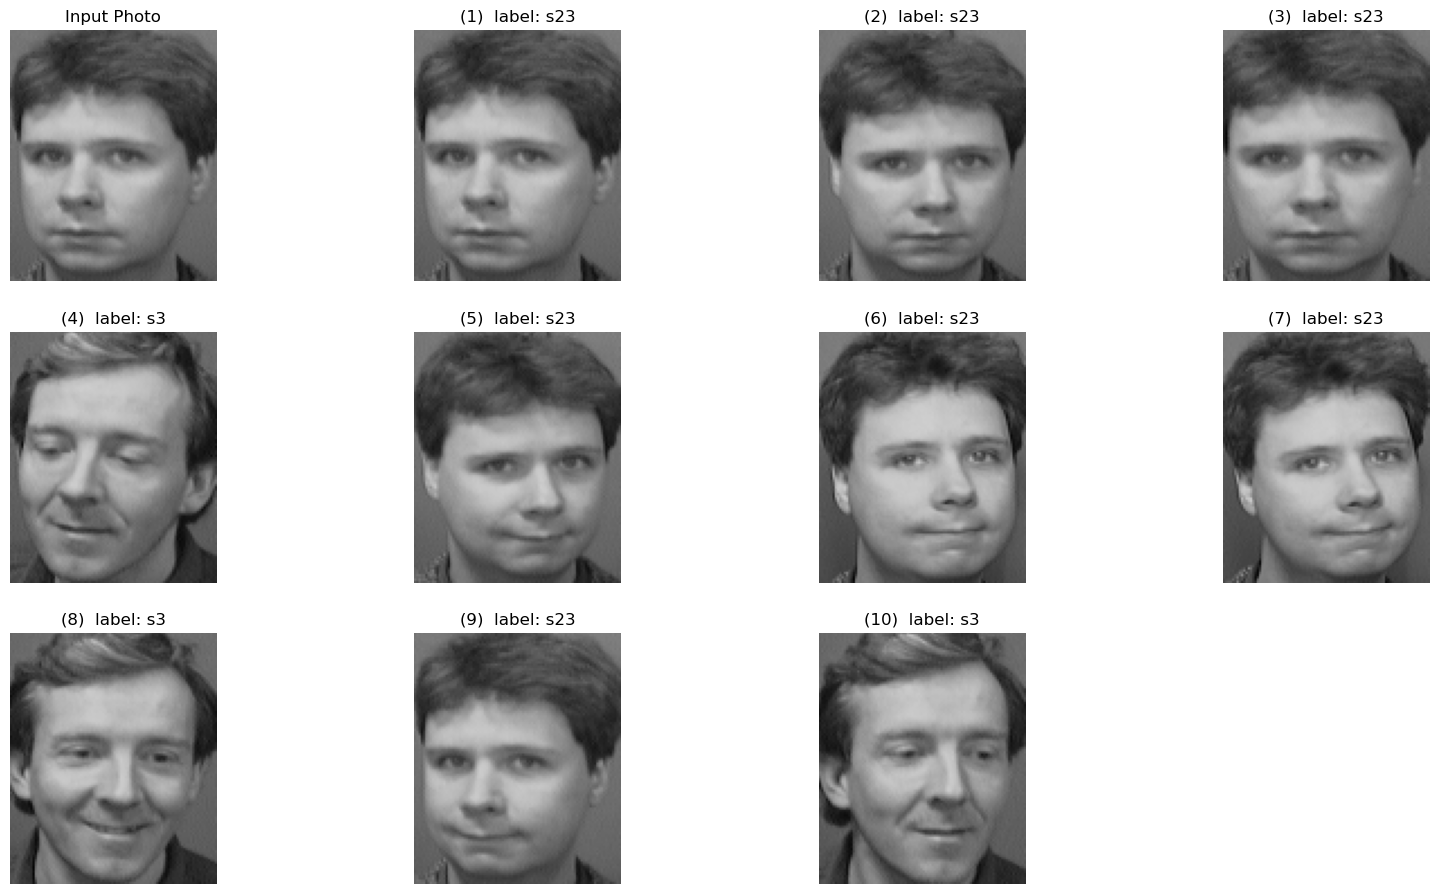

7 photos of those ten are in the same group as the input photo: 70.00%



In [59]:
def calculate_texture_feature(image, method="uniform"):
    
    # Convert the input image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Set parameters for Local Binary Pattern (LBP) computation
    radius = 1
    n_points = 8 * radius
    
    # Compute LBP using the specified method
    lbp = feature.local_binary_pattern(gray, n_points, radius, method=method)
    
    # Calculate the histogram of LBP features
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return hist

def compare_texture_features(feature1, feature2):
    
    # Calculate the chi-square histogram distance between two texture feature vectors
    distance = np.sum((feature1 - feature2) ** 2 / (feature1 + feature2 + 1e-10))
    return distance

def analyze_similarity(input_photo, input_feature, distances):
    
    # Sort distances in ascending order
    distances.sort(key=lambda x: x[0])
    
    # Select the top 10 photos with the smallest distances
    top_10_photos = distances[:10]
    
    # Create titles for the top 10 photos
    top_10_titles = [f"({i+1})  label: {label}" for i, (dist, label, _) in enumerate(top_10_photos)]
    
    # Display the input photo and the top 10 similar photos
    display_images(input_photo, [photo for _, _, photo in top_10_photos], top_10_titles)

    # Count the number of correct matches in the top 10 and calculate accuracy
    correct_count = sum(1 for _, label, _ in top_10_photos if label == distances[0][1])
    accuracy_percentage = (correct_count / 10) * 100
    print(f"\033[1m{correct_count}\033[0m photos of those ten are in the same group as the input photo: \033[1m{accuracy_percentage:.2f}%\033[0m\n")

def display_images(input_photo, similar_photos, titles, rows=4, cols=4):
    
    # Display input photo and similar photos with titles
    plt.figure(figsize=(20, 15))
    plt.subplot(rows, cols, 1)
    plt.imshow(cv2.cvtColor(input_photo, cv2.COLOR_BGR2RGB))
    plt.title("Input Photo")
    plt.axis("off")

    for i, (photo, title) in enumerate(zip(similar_photos, titles), start=1):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(photo, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")

    plt.show()
    
def load_dataset(dataset_path):
    
    # Load images and corresponding labels from the dataset
    X = []  # List to store texture features
    y = []  # List to store corresponding labels
    
    # Loop through each folder in the dataset path
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        
        # Check if the item in the folder path is a directory
        if os.path.isdir(folder_path):
            
            # Loop through each file in the folder
            photos = [filename for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))]
            np.random.shuffle(photos)
            train_size = int(len(photos) * 0.8)
            train_data = photos[:train_size]

            for filename in train_data:
                file_path = os.path.join(folder_path, filename)
                
                if os.path.isfile(file_path):
                    
                    # Read image, compute texture feature, and append to X and y
                    photo = cv2.imread(file_path)
                    photo_feature = calculate_texture_feature(photo)
                    X.append(photo_feature)
                    y.append(folder)

    return np.array(X), np.array(y)

if __name__ == "__main__":
    
    # Example usage of the functions
    input_photo_path = r"D:\Computer Vision\att_faces\s23\6.pgm"
    dataset_path = r"D:\Computer Vision\att_faces"

    input_photo = cv2.imread(input_photo_path)
    
    # Compute texture feature for the input photo
    input_feature = calculate_texture_feature(input_photo)

    distances = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        
        if os.path.isdir(folder_path):
            
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                
                if os.path.isfile(file_path):
                    
                    # Read image, compute texture feature, and calculate distance
                    photo = cv2.imread(file_path)
                    photo_feature = calculate_texture_feature(photo)
                    dist = compare_texture_features(input_feature, photo_feature)
                    distances.append((dist, folder, photo))
                    
    # Analyze the similarity between the input photo and the dataset
    analyze_similarity(input_photo, input_feature, distances)

---

This Python script defines functions for training a k-NN (k-Nearest Neighbors) classifier, evaluating its performance, finding pairs of individuals who frequently make mistakes together, and analyzing the overall system using an input photo and a dataset of facial images. 

The `train_knn` function trains a k-NN classifier with a specified number of neighbors. 

The `evaluate_system` function assesses the classifier's accuracy and produces a confusion matrix. 

The `find_cases_of_mistakes_together` function identifies pairs of individuals making mistakes together based on a mistake matrix. 

The `analyze_system` function splits the dataset into training and testing sets, trains a k-NN classifier, evaluates its performance, displays accuracy, and presents a mistake matrix along with cases where individuals make mistakes together. 

The main block assumes the existence of a `load_dataset` function, loads the dataset, and analyzes the system using an input photo, its features, and the dataset with a specified k value of 3.

In [60]:
def train_knn(X_train, y_train, k=3):
    
    # Train a k-NN classifier with the specified number of neighbors
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    return knn_classifier

def evaluate_system(X_test, y_test, knn_classifier):
    
    # Evaluate the performance of the system on the test set
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    return accuracy, confusion_mat

def find_cases_of_mistakes_together(mistakes_matrix, num_cases=2, labels=None):
    
    # Find pairs of people who make the most mistakes together
    flat_mistakes = mistakes_matrix.flatten()
    
    # Sort indices in descending order to identify pairs with the most mistakes
    sorted_indices = np.argsort(flat_mistakes)[::-1]
    
    selected_cases = []
    
    # Loop through sorted indices to find pairs
    for index in sorted_indices:
        person1, person2 = np.unravel_index(index, mistakes_matrix.shape)

        # Check if both individuals are from different classes 
        if labels is not None and labels[person1] != labels[person2]:
            
            # Add 1 to convert from 0-based index to 1-based index
            selected_cases.append((person1 + 1, person2 + 1))
            
            # Stop when the desired number of pairs is reached
            if len(selected_cases) == num_cases:
                break

    if len(selected_cases) > 0:
        print("\nCases of People Who Make a Lot of Mistakes Together:")
        for case in selected_cases:
            print(f"People \033[1m{case[0]}\033[0m and \033[1m{case[1]}\033[0m")

def analyze_system(input_photo, input_feature, dataset_features, dataset_labels, k=3):
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2, random_state=42)
    
    # Train a k-NN classifier
    knn_classifier = train_knn(X_train, y_train, k)
    
    # Evaluate the system's performance
    accuracy, confusion_mat = evaluate_system(X_test, y_test, knn_classifier)
    
    # Display results
    print("\033[1mA)\033[0m")
    print(f"\nAccuracy: \033[1m{accuracy * 100:.2f}%\033[0m\n")
    
    mistakes_matrix = confusion_mat - np.eye(len(confusion_mat))
    
    print("\033[1mB)\033[0m")
    print("\nMistakes Matrix:")
    print(mistakes_matrix)

    # Find cases where people make mistakes together
    find_cases_of_mistakes_together(mistakes_matrix, num_cases=2, labels=y_test)

if __name__ == "__main__":
    
    # Assuming load_dataset is defined elsewhere in your code
    X, y = load_dataset(dataset_path)
    
    # Analyze the system using the input photo and dataset
    analyze_system(input_photo, input_feature, X, y, k=3)

A)

Accuracy: 31.25%

B)

Mistakes Matrix:
[[ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

Cases of People Who Make a Lot of Mistakes Together:
People 8 and 3
People 4 and 2


---
# 2) 

The provided code defines a function `calculate_texture_feature_blocks` that computes Local Binary Pattern (LBP) features for a given image by dividing it into blocks of specified size (default: 3x3) and extracting LBP histograms from each block. The individual histograms are then concatenated to form a single feature vector representing the image's texture characteristics. 

In the main block, this function is used to calculate texture features for both the input photo and each photo in a dataset, considering 3x3 blocks. The distances between the input photo and dataset photos are computed using a comparison function, and the results are then analyzed for similarity. 

Additionally, the script assumes the existence of a `load_dataset` function for loading the dataset, and it utilizes the `analyze_system` function to evaluate the overall system performance using the input photo and the calculated texture features with a specified k value of 3 in a k-NN classifier.

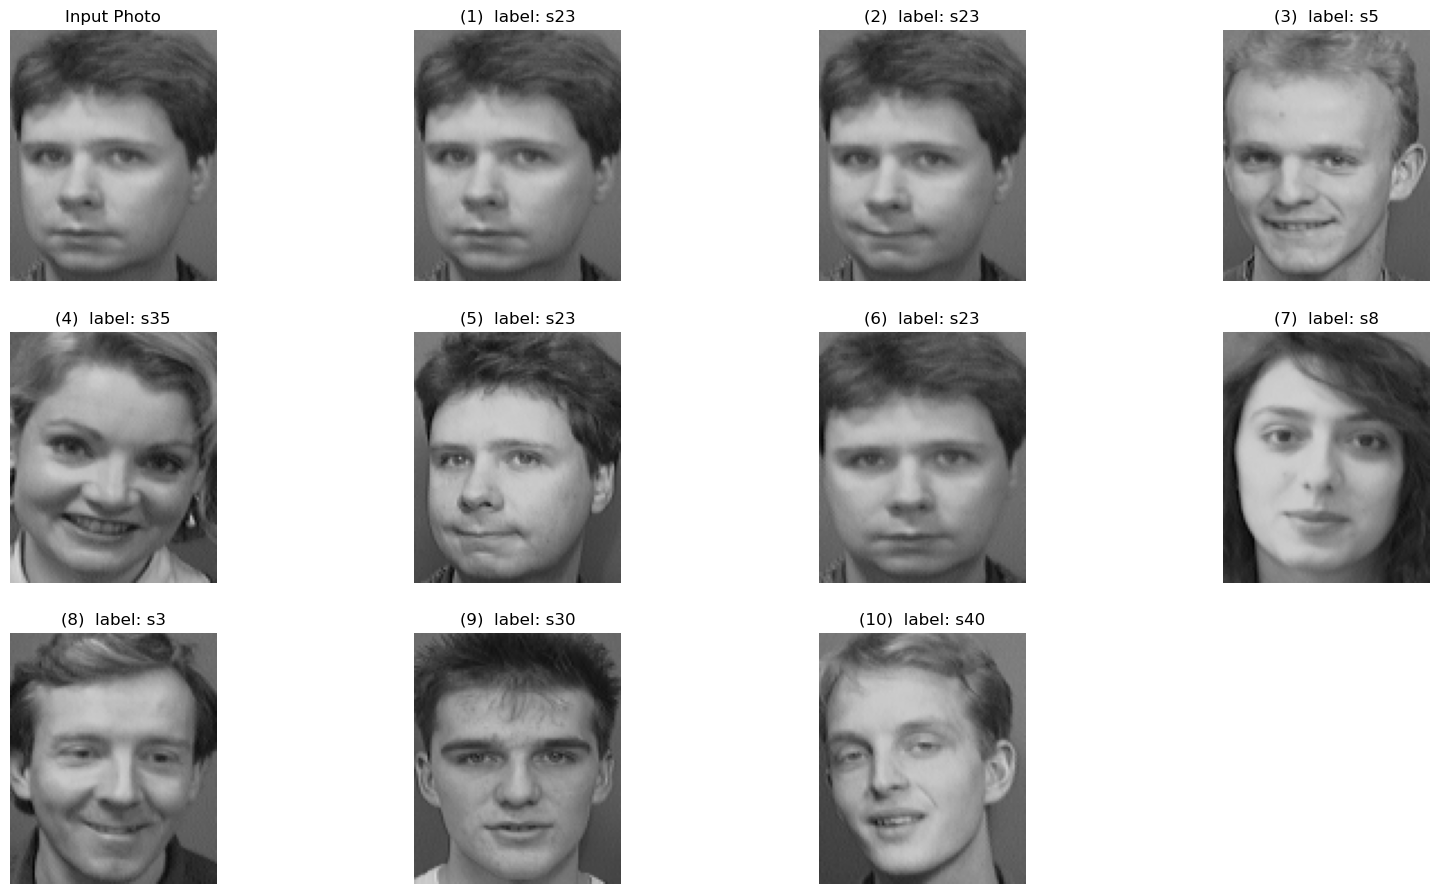

4 photos of those ten are in the same group as the input photo: 40.00%

A)

Accuracy: 31.25%

B)

Mistakes Matrix:
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  1. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]

Cases of People Who Make a Lot of Mistakes Together:
People 37 and 7
People 26 and 9


In [61]:
def calculate_texture_feature_blocks(image, method="uniform", block_size=(3, 3)):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 1
    n_points = 8 * radius

    # Divide the image into blocks
    blocks = [gray[i:i + block_size[0], j:j + block_size[1]] for i in range(0, gray.shape[0], block_size[0]) for j in
              range(0, gray.shape[1], block_size[1])]

    # Calculate LBP features for each block
    block_features = []
    for block in blocks:
        lbp = feature.local_binary_pattern(block, n_points, radius, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= hist.sum()
        block_features.append(hist)

    # Combine the block features into a single feature vector
    combined_feature = np.concatenate(block_features)
    return combined_feature


if __name__ == "__main__":

    # Calculate texture feature for 3x3 blocks
    input_feature_blocks = calculate_texture_feature_blocks(input_photo)

    distances = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if os.path.isfile(file_path):
                    photo = cv2.imread(file_path)

                    # Calculate texture feature for 3x3 blocks for each photo
                    photo_feature_blocks = calculate_texture_feature_blocks(photo)

                    # Compare the features
                    dist = compare_texture_features(input_feature_blocks, photo_feature_blocks)
                    distances.append((dist, folder, photo))

    analyze_similarity(input_photo, input_feature, distances)
    X, y = load_dataset(dataset_path)
    analyze_system(input_photo, input_feature_blocks, X, y, k=3)